In [2]:
# to print all output for a cell instead of only last one 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
import utils_analytics as ut
import pandas as pd
import src.globals as glob
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Introduction

Bla bla bla

### Dataset

In [4]:
tweets_df, account_df = ut.loadData()
tweets_df.head()

,account_id,tweet,label,split
0,17461978,RT @CarnivalCruise: 🎉 Are you ready to see wha...,0,train
1,17461978,Who has time for receipts? Not me. @epson rece...,0,train
2,17461978,Steady wants to encourage you to invest in you...,0,train
3,17461978,"Good one, @rishid. But let’s see if y'all can ...",0,train
4,17461978,#lsunationalchamps\n,0,train


### Preprocessing text

Esempio testo tweet originale:

In [5]:
print(tweets_df.loc[9,'tweet'])

We did it! The first ever #SHAQvsGRONK had over 9 MILLION live viewers who helped @GRONK and I raise money for the @NAACP and @BGCCAN with 1.25 million meals donated to @FeedingAmerica. A big shoutout to @TheGeneralAuto and everyone who performed. Watch this  👀 (🎥: @lanreako) https://t.co/sf7EVKjROT



Come è possibile vedere, i tweet presentano solitamente hashtag, menzioni, url ecc.. che però difficilmente si riescono ad encodare come informazioni utili da passare in input ad una LSTM. Pertanto uno step di preprocessing è sicuramente necessario per ridurre il numero di OOV words mantenendo intatte il più possibile le informazioni che questi dati possiedono.

Step di preprocessing per ogni singolo tweet:
- 'RT' -> ' retweet '
- '\n' -> ' '
- '$apple' -> ' stock '
- '@' -> ' email '
- '1,2,3..' -> ' number '
- '$,£..' -> ' money '
- '#' -> ' hashtag '
- '@pontifex' -> ' username '

- 'http,https..' -> 'url'
- 'ahah, haha, ajaj, jaja' -> 'ahah'
- '-' -> ' '
- "'" -> " '"
- Remove tweets too shorts (minimum 3 tokens required)

Perchè lo facciamo così:
- cashtag, money, emoji:
- esclusione tweet corti: abbiamo deciso di eliminare i tweet che dopo il preprocessing possedevano un numero di token inferiore a 3. Questo ha permesso di 'pulire' il dataset da tweet poco esplicativi (anche per un umano) che avrebbero costituito degli outlier e che avrebbero peggiorato le performance
- inglese vs altre lingue: 
- FastText vs Glove:

Testo pulito:

Stampare esempi testo pulito

In [6]:
dataset_df = pd.read_pickle(glob.DATA_FOLDER / 'processed_dataset_v1.pkl')
dataset_df.head()

,account_id,tweet,label,split,processed_tweet
0,17461978,RT @CarnivalCruise: 🎉 Are you ready to see wha...,0.0,train,"[retweet, emoji, are, you, ready, to, see, wha..."
1,17461978,Who has time for receipts? Not me. @epson rece...,0.0,train,"[who, has, time, for, receipts, ?, not, me, .,..."
2,17461978,Steady wants to encourage you to invest in you...,0.0,train,"[steady, wants, to, encourage, you, to, invest..."
3,17461978,"Good one, @rishid. But let’s see if y'all can ...",0.0,train,"[good, one, ,, username, ., but, let, ’, s, se..."
4,17461978,#lsunationalchamps\n,0.0,train,[hashtag]


In [7]:
print(dataset_df.loc[9,'processed_tweet'])

['we', 'did', 'it', '!', 'the', 'first', 'ever', 'hashtag', 'had', 'over', 'number', 'million', 'live', 'viewers', 'who', 'helped', 'username', 'and', 'i', 'raise', 'money', 'for', 'the', 'username', 'and', 'username', 'with', 'number', 'million', 'meals', 'donated', 'to', 'username', '.', 'a', 'big', 'shoutout', 'to', 'username', 'and', 'everyone', 'who', 'performed', '.', 'watch', 'this', 'emoji', '(', 'emoji', ':', 'username', ')', 'url']


### Text of single tweet
- architettura modello
- da testo a embedding 
- tuning hyperparametri 
- motivare : dropout, weight decay, class imbalance  
- risultati

### Text of single tweet + text features 
- Perchè utilizziamo delle feature ( la LSTM non considera troppo elementi statistici del testo come RT, hashtag, numeri di cose, ecc..)
- Come le passiamo: struttura modello + zscore 
- Feature utilizzate:
    - Is retweet? Yes/No
    - N° of URLs, tags, hashtags, cashtag, currency simbols, emails, numbers, emoticons, emojis, stopwords, punctuation
- Perchè queste feature? rilevanza, analisi di correlazione
- Esempi di tweet che mostrano la rilevanza delle feature (i bot tendono a avere più citazioni, hashtag, boh ) risultati 


In [8]:
text_features_df = pd.read_pickle(glob.DATA_FOLDER / 'processed_dataset_v2.pkl')
text_features_df.head()

,account_id,tweet,label,split,processed_tweet,is_rt,url_c,tag_c,hashtag_c,cashtag_c,money_c,email_c,number_c,emoji_c,emoticon_c,len_tweet,stopwords_c,punct_c
0,17461978,RT @CarnivalCruise: 🎉 Are you ready to see wha...,0.0,train,"[retweet, emoji, are, you, ready, to, see, wha...",1.0,-0.860575,-0.453232,-0.340005,-0.025697,-0.113227,-0.047398,-0.349871,1.110997,-0.131432,0.828308,1.258624,0.035739
1,17461978,Who has time for receipts? Not me. @epson rece...,0.0,train,"[who, has, time, for, receipts, ?, not, me, .,...",0.0,2.275474,0.138502,-0.340005,-0.025697,-0.113227,-0.047398,-0.349871,-0.263783,-0.131432,0.679442,0.912668,1.920457
2,17461978,Steady wants to encourage you to invest in you...,0.0,train,"[steady, wants, to, encourage, you, to, invest...",0.0,3.843499,0.138502,0.464529,-0.025697,5.927650,-0.047398,-0.349871,-0.263783,-0.131432,2.093667,1.604579,1.449277
3,17461978,"Good one, @rishid. But let’s see if y'all can ...",0.0,train,"[good, one, ,, username, ., but, let, ’, s, se...",0.0,2.275474,0.138502,1.269062,-0.025697,-0.113227,-0.047398,-0.349871,-0.263783,-0.131432,0.977174,0.912668,1.920457
4,17461978,#lsunationalchamps\n,0.0,train,[hashtag],0.0,-0.860575,-0.453232,0.464529,-0.025697,-0.113227,-0.047398,-0.349871,-0.263783,-0.131432,-1.404677,-0.990085,-0.906621


<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

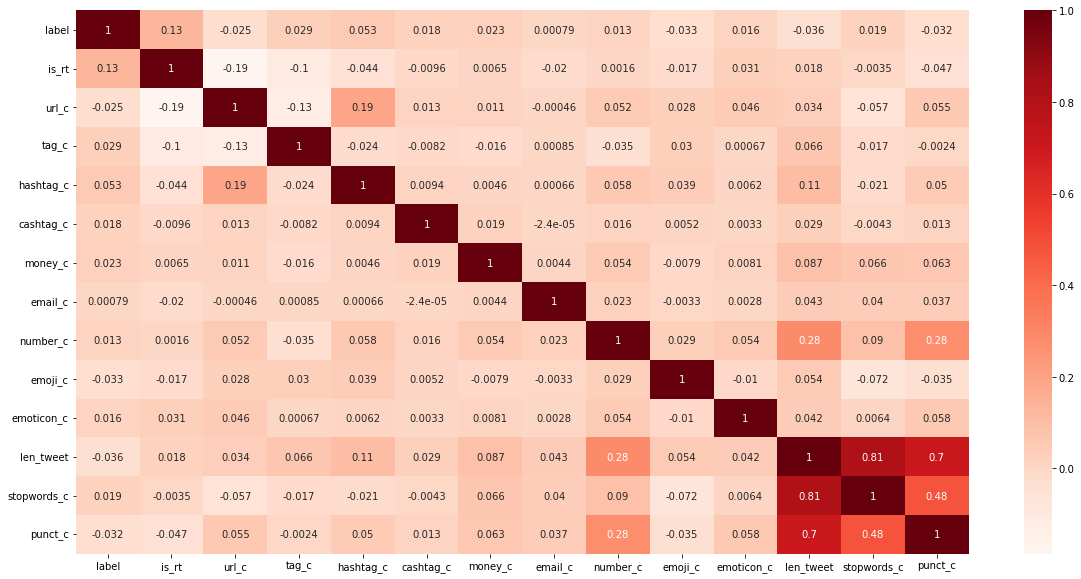

In [9]:
plt.figure(figsize=(20,10))
cor = text_features_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

0 -> is_rt: 66.622%
1 -> url_c: 2.302%
2 -> tag_c: 2.505%
3 -> hashtag_c: 10.645%
4 -> cashtag_c: 1.169%
5 -> money_c: 1.790%
6 -> email_c: 0.026%
7 -> number_c: 0.727%
8 -> emoji_c: 3.323%
9 -> emoticon_c: 0.637%
10 -> len_tweet: 5.080%
11 -> stopwords_c: 1.011%
12 -> punct_c: 4.162%


<Figure size 2160x720 with 0 Axes>

<BarContainer object of 13 artists>

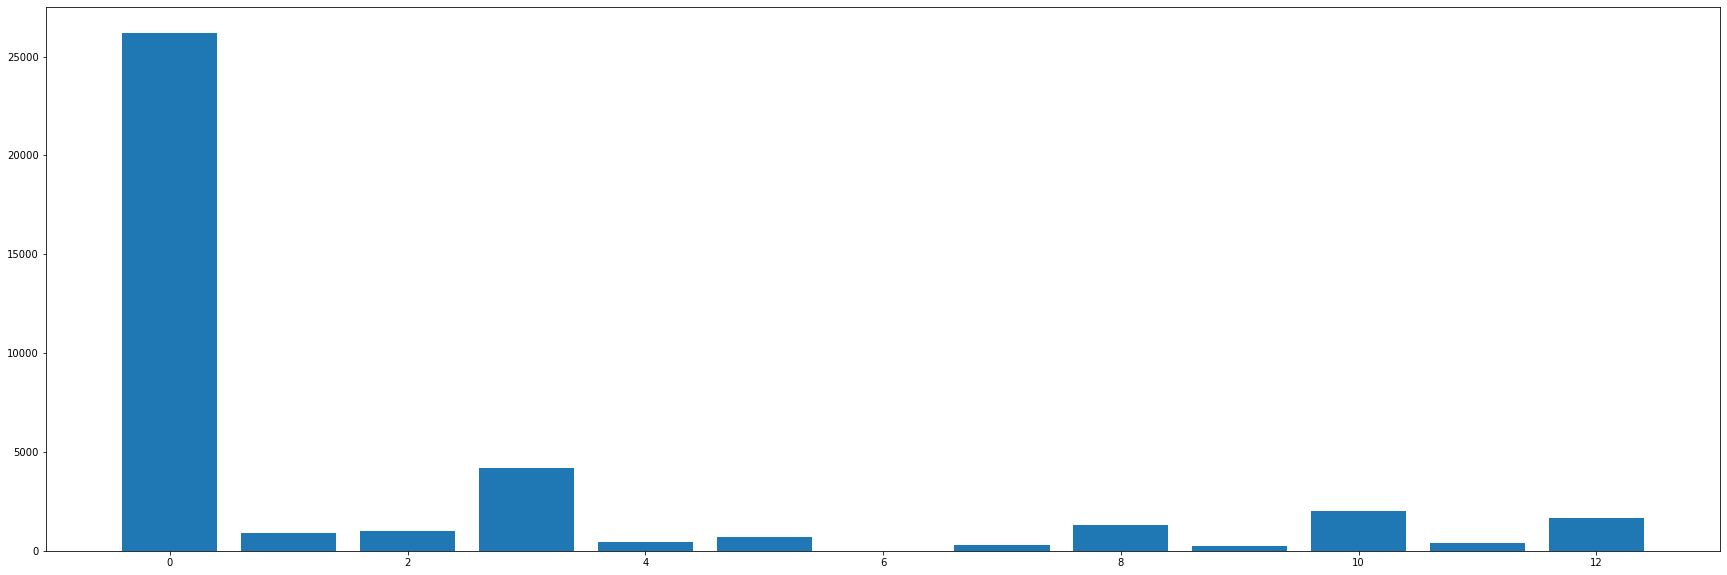

In [11]:
feature_columns = ['is_rt','url_c','tag_c','hashtag_c','cashtag_c','money_c','email_c','number_c','emoji_c','emoticon_c','len_tweet','stopwords_c','punct_c']
train_ds = text_features_df[text_features_df['split'] == 'train'].reset_index(drop=True)
val_ds = text_features_df[text_features_df['split'] == 'val'].reset_index(drop=True)
test_ds = text_features_df[text_features_df['split'] == 'test'].reset_index(drop=True)

X_train = train_ds[feature_columns]
y_train = train_ds['label']

X_test = val_ds[feature_columns]
y_test = val_ds['label']

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print(f'{i} -> {feature_columns[i]}: {fs.scores_[i]/sum(fs.scores_)*100:.3f}%')
# plot the scores

plt.figure(figsize=(30,10))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Come è possibile vedere, la feature 'is_rt' (Is retweet? Yes/No) sia molto correlata al valore della label (Bot/Human). Andiamo pertanto ad analizzare le percentuali che caratterizzano la differenza tra tweet prodotti da bot che sono retweet o post 'nuovi'.

In [30]:
num_rt_bot = text_features_df[(text_features_df['is_rt'] == 1.0) & (text_features_df['label'] == 1.0)].shape[0]
num_nort_bot = text_features_df[(text_features_df['is_rt'] == 0.0) & (text_features_df['label'] == 1.0)].shape[0]
num_tweets = text_features_df.shape[0]
print(f'Number of tweets from bots which are retweet: {num_rt_bot} - ({num_rt_bot/num_tweets*100:.1f}%)')
print(f'Number of tweets from bots which are not retweet: {num_nort_bot} - ({num_nort_bot/num_tweets*100:.1f}%)\n')

num_rt_human = text_features_df[(text_features_df['is_rt'] == 1.0) & (text_features_df['label'] == 0.0)].shape[0]
num_nort_human = text_features_df[(text_features_df['is_rt'] == 0.0) & (text_features_df['label'] == 0.0)].shape[0]
print(f'Number of tweets from humans which are retweet: {num_rt_human} - ({num_rt_human/num_tweets*100:.1f}%)')
print(f'Number of tweets from humans which are not retweet: {num_nort_human} - ({num_nort_human/num_tweets*100:.1f}%)\n')

print(f"Pearson Correlation:\n{text_features_df[['is_rt','label']].corr()}")

Number of tweets from bots which are retweet: 407488 - (20.4%)
Number of tweets from bots which are not retweet: 665008 - (33.3%)

Number of tweets from humans which are retweet: 237330 - (11.9%)
Number of tweets from humans which are not retweet: 689962 - (34.5%)

Pearson Correlation:
        is_rt   label
is_rt  1.0000  0.1323
label  0.1323  1.0000


Quindi c'è una probabilità doppia che se il tweet è un retweet l'utente sia in realtà un bot.

Andiamo ora invece ad effettuare lo stesso studio sulla feature 'cashtag_c', che mostra il numero di cashtag all'interno di ogni singolo tweet e che appare molto poco correlata alla label finale.

In [35]:
print(f"Pearson Correlation:\n{text_features_df[['cashtag_c','label']].corr()}")

Pearson Correlation:
           cashtag_c     label
cashtag_c   1.000000  0.017785
label       0.017785  1.000000


Infine andiamo a comparare la media di url utilizzati per singolo tweet da bot e umani con la corrispondente media di hashtag.

In [38]:
mean_url_bot = text_features_df[text_features_df['label'] == 1.0]['url_c'].mean()
mean_url_nobot = text_features_df[text_features_df['label'] == 0.0]['url_c'].mean()
print(f"Average z-score of URLs per single tweet by bot user: {mean_url_bot:.3f}")
print(f"Average z-score of URLs per single tweet by human user: {mean_url_nobot:.3f}")
print(f"Difference: {abs(mean_url_bot - mean_url_nobot):.3f}")

Average z-score of URLs per single tweet by bot user: -0.024
Average z-score of URLs per single tweet by human user: 0.027
Difference: 0.051


In [40]:
mean_hashtag_bot = text_features_df[text_features_df['label'] == 1.0]['hashtag_c'].mean()
mean_hashtag_nobot = text_features_df[text_features_df['label'] == 0.0]['hashtag_c'].mean()
print(f"Average z-score of hashtags per single tweet by bot user: {mean_hashtag_bot:.3f}")
print(f"Average z-score of hashtags per single tweet by human user: {mean_hashtag_nobot:.3f}")
print(f"Difference: {abs(mean_hashtag_bot - mean_hashtag_nobot):.3f}")

Average z-score of hashtags per single tweet by bot user: 0.050
Average z-score of hashtags per single tweet by human user: -0.057
Difference: 0.107


Il margine è nettamente più ampio (più del doppio)